In [1]:
import re
import ast
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities import MatrixSimilarity
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kennethsee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kennethsee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import, merge, and transform data

In [2]:
# import patient and video data into dataframes
df_patient = pd.read_csv('./Data/patient_info_CONFIDENTIAL.csv')
df_video = pd.read_csv('./Data/video_watched_events_CONFIDENTIAL.csv')


In [3]:
# rename datetime_created column names
df_video = df_video.rename(columns={'datetime_created':'datetime_created_video'})
df_patient = df_patient.rename(columns={'datetime_created':'datetime_created_patient'})

## Map Categories

Age categories are mapped as follow

| Age Category | Lower Bound | Upper Bound |
| --- | --- | --- |
| GIGeneration | 93 | 119 |
| SilentGeneration | 75 | 92 |
| Boomers | 56 | 74 |
| GenX | 40 | 55 |
| Millenials | 24 | 39 |
| GenZ | 8 | 23 |
| GenAlpha | 0 | 7 |

In [4]:
# map age categories
def age_mapper(age):
    '''
    Takes in an age as an integer and maps it to the respective age category
    '''
    age_cat = ""
    
    if 93 <= age <= 119:
        age_cat = "GIGeneration"
    elif 75 <= age <= 92:
        age_cat = "SilentGeneration"
    elif 56 <= age <= 74:
        age_cat = "Boomers"
    elif 40 <= age <= 55:
        age_cat = "GenX"
    elif 24 <= age <= 39:
        age_cat = "Millenials"
    elif 8 <= age <= 23:
        age_cat = "GenZ"
    elif 0 <= age <= 7:
        age_cat = "GenAlpha"
    else: # handle edge cases
        age_cat = ""
    
    return age_cat

df_patient['age_category'] = df_patient['age'].apply(age_mapper)

AxesSubplot(0.125,0.125;0.775x0.755)


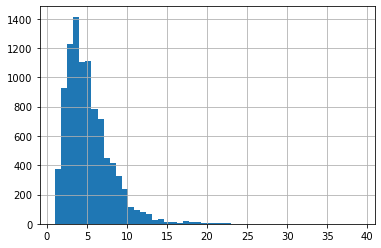

In [5]:
# EDA for viewer activeness
df_patient['viewer_activeness_ratio'] = df_patient['total_activities_done']/df_patient['unique_days_with_activity']
print(df_patient['viewer_activeness_ratio'].hist(bins=50))

Viewer Activeness Ratio is classified as follows:

| Lowest Number of Videos Watched (per day) | Most Number of Videos Watched (per day) | Activeness Category |
| --- | --- | --- |
| 0 | 1.99 | Inactive |
| 2 | 3.99 | Sedentary |
| 4 | 5.99 | Light |
| 6 | 7.99 | Moderate |
| 8 | 9.99 | Active |
| 10 | 11.99 | Vigorous |
| 12 | above | Very Vigorous |

In [6]:
# map viewer activeness category
def activeness_mapper(ratio):
    
    cat = ''
    
    if ratio < 2:
        cat = 'Inactive'
    elif 2 <= ratio < 4:
        cat = 'Sedentary'
    elif 4 <= ratio < 6:
        cat = 'Light'
    elif 6 <= ratio < 8:
        cat = 'Moderate'
    elif 8 <= ratio < 10:
        cat = 'Active'
    elif 10 <= ratio < 12:
        cat = 'Vigorous'
    else:
        cat = 'Very Vigorous'
        
    return cat

df_patient['activeness_category'] = df_patient['viewer_activeness_ratio'].apply(activeness_mapper)

# Topic Modeling with LDA

## Preprocess strings

In [7]:
df_video['tags'] = df_video['tags'].replace(np.nan, '[\'\']')
df_video['tags'] = df_video['tags'].apply(ast.literal_eval)

In [8]:
# remove numbers and websites
def no_number_and_website_preprocessor(tokens):
    r = re.sub(r'\d+', '', str(tokens))
    r = re.sub(r'http\S+', '', r)
    return r

df_video['notes'] = df_video['notes'].apply(no_number_and_website_preprocessor)

In [9]:
# combine notes and tags
def combine_list(lst):
    return ' '.join(lst)

df_video['tags'] = df_video['tags'].apply(combine_list)
df_video['notes_and_tags'] = df_video['notes'] + ' ' + df_video['tags']

# make lower case
df_video['notes_and_tags'] = df_video['notes_and_tags'].str.lower()

df_video.head()

,datetime_created_video,id,patient_id,video_id,homework_id,subsection_watched_from,url,primary_category,secondary_category,notes,description,tags,length,notes_and_tags
0,2020-03-20 12:09:40.503569,50948,26207,624,NaN,Featured,https://www.youtube.com/watch?v=CxVsxOH0yGA,NaN,[''],Why Uncertainty Sucks (and how to deal with it),Get the first 30 days of Curiosity Stream free...,brain braincraft brain craft psychology uncert...,466,why uncertainty sucks (and how to deal with it...
1,2020-02-13 04:11:27.120579,38875,26207,620,NaN,Featured,https://www.youtube.com/watch?v=0AIEqUq6q1U,Anxiety,['Sleep'],Why We Worry So Much,http://www.cloudlessmind.com - Why do we worry...,Paul Smit Scott Byrd Advaita Nonduality Change...,137,why we worry so much paul smit scott byrd adva...
2,2020-02-22 12:31:55.011380,42215,26207,620,NaN,Recently Watched,https://www.youtube.com/watch?v=0AIEqUq6q1U,Anxiety,['Sleep'],Why We Worry So Much,http://www.cloudlessmind.com - Why do we worry...,Paul Smit Scott Byrd Advaita Nonduality Change...,137,why we worry so much paul smit scott byrd adva...
3,2020-01-13 04:30:36.606531,27614,26207,787,NaN,Featured,https://www.youtube.com/watch?v=fAjdI7J4Gvo,NaN,[''],Science-Backed Ways to Relieve Stress Right Now!,To support our channel and level up your healt...,relieve stress how to relieve stress stress re...,285,science-backed ways to relieve stress right n...
4,2020-01-03 11:37:00.498739,24201,26207,771,NaN,Featured,https://youtu.be/otFrNM7PnME?t=3,Cognitive Behavioral Therapy,"['Depression', 'Anxiety', 'Stress', 'Managing ...",Cognitive Distortions,A person's thoughts and beliefs—whether they'r...,cbt psychotherapy cognitive distortions therap...,305,cognitive distortions cbt psychotherapy cognit...


In [10]:
# initialize wordnet lemmatizer
lemmatizer = WordNetLemmatizer()

In [11]:
# tokenize words
df_video['notes_and_tags'] = df_video['notes_and_tags'].apply(nltk.word_tokenize)

In [12]:
# lemmatize words
def lemmatize_list_of_words(words):
    new_list = []
    for word in words:
        new_list.append(lemmatizer.lemmatize(word))
    return new_list

df_video['notes_and_tags'] = df_video['notes_and_tags'].apply(lemmatize_list_of_words)

In [13]:
# join back words to string
df_video['notes_and_tags'] = df_video['notes_and_tags'].apply(combine_list)

## Fit into topical model

In [14]:
# create instance of Counter Vectorizer
cv = CountVectorizer(max_df = 0.90, min_df = 2, stop_words = 'english')

# fit and transform text data
cv_fit = cv.fit_transform(df_video['notes_and_tags'])


In [15]:
# create instance for LDA
lda = LatentDirichletAllocation(n_components = 20, random_state = 1)

# fit the LDA
lda.fit(cv_fit)


LatentDirichletAllocation(n_components=20, random_state=1)

In [16]:
feature = cv.get_feature_names()

topic_map = {}

for ind, topic in enumerate(lda.components_):
    print(f'Top 3 words in topic {ind}')
    print('-'*10)
    top_3 = topic.argsort()[-3:]
    topic_words = [feature[i] for i in top_3]
    print(topic_words, '\n')
    # add to topic map
    topic_map[ind] = topic_words

Top 3 words in topic 0
----------
['mindfulness', 'meditation', 'breathing'] 

Top 3 words in topic 1
----------
['cognitive', 'automatic', 'thought'] 

Top 3 words in topic 2
----------
['management', 'smart', 'goal'] 

Top 3 words in topic 3
----------
['guided', 'meditation', 'sleep'] 

Top 3 words in topic 4
----------
['emotional', 'dimension', 'wellness'] 

Top 3 words in topic 5
----------
['neuroflow', 'mental', 'health'] 

Top 3 words in topic 6
----------
['video', 'motivational', 'purpose'] 

Top 3 words in topic 7
----------
['anxiety', 'china', 'coronavirus'] 

Top 3 words in topic 8
----------
['minute', 'health', 'pain'] 

Top 3 words in topic 9
----------
['major', 'depressive', 'disorder'] 

Top 3 words in topic 10
----------
['positive', 'meditation', 'psychology'] 

Top 3 words in topic 11
----------
['mental', 'health', 'therapy'] 

Top 3 words in topic 12
----------
['attack', 'stress', 'anxiety'] 

Top 3 words in topic 13
----------
['brain', 'skill', 'depression'

In [17]:
# assign topics to df
df_final = lda.transform(cv_fit)
df_video['topic'] = df_final.argmax(axis = 1)

In [18]:
# map topic words
df_video['topic_words'] = df_video['topic'].map(topic_map)
df_video.head()

,datetime_created_video,id,patient_id,video_id,homework_id,subsection_watched_from,url,primary_category,secondary_category,notes,description,tags,length,notes_and_tags,topic,topic_words
0,2020-03-20 12:09:40.503569,50948,26207,624,NaN,Featured,https://www.youtube.com/watch?v=CxVsxOH0yGA,NaN,[''],Why Uncertainty Sucks (and how to deal with it),Get the first 30 days of Curiosity Stream free...,brain braincraft brain craft psychology uncert...,466,why uncertainty suck ( and how to deal with it...,13,"[brain, skill, depression]"
1,2020-02-13 04:11:27.120579,38875,26207,620,NaN,Featured,https://www.youtube.com/watch?v=0AIEqUq6q1U,Anxiety,['Sleep'],Why We Worry So Much,http://www.cloudlessmind.com - Why do we worry...,Paul Smit Scott Byrd Advaita Nonduality Change...,137,why we worry so much paul smit scott byrd adva...,5,"[neuroflow, mental, health]"
2,2020-02-22 12:31:55.011380,42215,26207,620,NaN,Recently Watched,https://www.youtube.com/watch?v=0AIEqUq6q1U,Anxiety,['Sleep'],Why We Worry So Much,http://www.cloudlessmind.com - Why do we worry...,Paul Smit Scott Byrd Advaita Nonduality Change...,137,why we worry so much paul smit scott byrd adva...,5,"[neuroflow, mental, health]"
3,2020-01-13 04:30:36.606531,27614,26207,787,NaN,Featured,https://www.youtube.com/watch?v=fAjdI7J4Gvo,NaN,[''],Science-Backed Ways to Relieve Stress Right Now!,To support our channel and level up your healt...,relieve stress how to relieve stress stress re...,285,science-backed way to relieve stress right now...,12,"[attack, stress, anxiety]"
4,2020-01-03 11:37:00.498739,24201,26207,771,NaN,Featured,https://youtu.be/otFrNM7PnME?t=3,Cognitive Behavioral Therapy,"['Depression', 'Anxiety', 'Stress', 'Managing ...",Cognitive Distortions,A person's thoughts and beliefs—whether they'r...,cbt psychotherapy cognitive distortions therap...,305,cognitive distortion cbt psychotherapy cogniti...,1,"[cognitive, automatic, thought]"


# Cleaning and Preparing Data

In [19]:
# clean primary and secondary category columns
df_video['primary_category'] = df_video['primary_category'].replace(np.nan,'')
df_video['secondary_category'] = df_video['secondary_category'].replace(np.nan, '[\'\']')

In [20]:
# convert secondary category to list
df_video['secondary_category'] = df_video['secondary_category'].apply(ast.literal_eval)

In [21]:
# create training dataframe
# initialize dictionary and list
patient_dict = {}
list_of_key_words = []

# iterate through patient df
for i, row in df_patient.iterrows():
    #reset list of key words
    list_of_key_words = []

    # get this patient's patient id
    patient_id = row['patient_id']
    
    # add patient's sex
    list_of_key_words.append(row['sex'].lower())
    
    # add patient's age category
    list_of_key_words.append(row['age_category'])
    
    # add patient's viewer activeness category
    list_of_key_words.append(row['activeness_category'])

    # search through video df
    for j, video_row in df_video[df_video['patient_id'] == patient_id].iterrows():
        # append words in primary and secondary category to list of key words
        if video_row['primary_category'] != '':
            list_of_key_words.append(video_row['primary_category'].lower())
        for word in video_row['secondary_category']:
            if word != '':
                list_of_key_words.append(word.lower())

        for topic in video_row['topic_words']:
            list_of_key_words.append(topic)

    # add entry to patient dictionary
    patient_dict[patient_id] = list_of_key_words


In [22]:
# convert patient dictionary to training dataframe
df_train = pd.DataFrame(list(patient_dict.items()), columns=['patient_id', 'key_words'])
df_train.head()

,patient_id,key_words
0,26207,"[female, GenX, Light, brain, skill, depression..."
1,26208,"[male, Boomers, Inactive, neuroflow, mental, h..."
2,26209,"[male, Boomers, Light, brain, skill, depressio..."
3,26211,"[female, GenX, Moderate, anxiety, brain, skill..."
4,26212,"[male, Millenials, Inactive, managing pain, fi..."


# Recommendation Model


We will be using cosine similarity to get the closest patients to the patient given based on scraped keywords.
We then get the ranked videos that each of the closest patients watched based on frequency of watching, then recommend
the highest 3 ranked videos that the patient given has not already watched.


## Model to Find Closest Patients

In [23]:
# create dictionary of words
list_of_key_words = df_train['key_words'].to_list()
dictionary = Dictionary(list_of_key_words)

In [24]:
# create genism corpus
corpus = [dictionary.doc2bow(doc) for doc in list_of_key_words]

In [25]:
# convert corpus into tf-idf model
tfidf = TfidfModel(corpus)

# get similarity
sims = MatrixSimilarity(tfidf[corpus], num_features = len(dictionary))

In [26]:
# function to get similar patients
def patient_recommendation(patient_id):
    '''
    Takes in a patient ID and recommends all the closest patients. Closest patients are determined by cosine similarity
    with a score of at least 0.85.
    '''
    # get patient row
    patient = df_train.loc[df_train['patient_id'] == patient_id]
    
    # get keywords
    key_words = patient['key_words'].iloc[0]
    query_doc = key_words
 
    # get bag of words and convert into model
    query_doc_bow = dictionary.doc2bow(query_doc)
    query_doc_tfidf = tfidf[query_doc_bow]
    
    # get similarity array
    similarity_array = sims[query_doc_tfidf]
    
    # arrange results by top matching
    similarity_series = pd.Series(similarity_array.tolist(), index=df_train['patient_id'].values)
    top_recs = similarity_series.sort_values(ascending=False)[1::] # exclude self
    
    # return list of recommendations
#     sorted_tfidf_weights = sorted(tfidf[corpus[df_test.index.values.tolist()[0]]], key=lambda w:w[1], reverse=True)
    rec = []
    for id, (patient, score) in enumerate(zip(top_recs.index, top_recs)):
        # only add if score >= 0.85
        if score >= 0.85:
            rec.append((patient, score))
        
    return rec

In [27]:
# CHOOSE PATIENT THAT RECOMMENDATION WOULD BE MADE FOR
# note: chosen patient ID must exist in the patient database
rec_patient_id = 26207 # REPLACE ID HERE

In [28]:
# Get recommended patients
recommendation = patient_recommendation(rec_patient_id)

print('The following patients are closest to patient ' + str(rec_patient_id) + ':')
for rec in recommendation:
    print('Patient ' + str(rec[0]) + ' with a closeness of ' + str(round(rec[1] * 100, 2)) + '%')

The following patients are closest to patient 26207:
Patient 56343 with a closeness of 89.33%
Patient 26925 with a closeness of 88.12%
Patient 63051 with a closeness of 85.93%
Patient 66733 with a closeness of 85.63%
Patient 66287 with a closeness of 85.01%


In [29]:
# Uncomment and run this block to check accuracy of prediction
# recommended_patient_id = 37620 # CHANGE THIS ID BASED ON PATIENTS RETURNED FROM PATIENT RECOMMENDER

# print('Key words for patient ' + str(rec_patient_id))
# print(df_train[df_train['patient_id'] == rec_patient_id].key_words.iloc[0])
# print('\n')
# print('Key words for patient ' + str(recommended_patient_id))
# print(df_train[df_train['patient_id'] == recommended_patient_id].key_words.iloc[0])

## Perform Video Recommendations

In this final step, we first obtain all the videos watched by the recommended patients and consolidate the total times each video is watched among them.

In [30]:
# create top videos by patient dictionary
top_videos_by_patient_dict = {}
video_frequency = {}
top_5_videos = []

# iterate through patient df
for i, row in df_patient.iterrows():
    #reset video frequency and top 5 videos
    video_frequency = {}
    top_5_videos = []

    # get this patient's patient id
    patient_id = row['patient_id']

    # iterrate through videos
    for j, video_row in df_video[df_video['patient_id'] == patient_id].iterrows(): 

        # get video id
        video_id = video_row['video_id']

        # check if video id already exists in video frequency dictionary
        if video_id in video_frequency:
            # increment frequency if video already exists in dictionary
            video_frequency[video_id] += 1
        else: # video does not yet exist in dictionary
            # create a new key value pair with key as video and value as 1
            video_frequency[video_id] = 1

    # find top 5 most watched videos
    counter = Counter(video_frequency)
    top_videos_counter = counter.most_common(5)
    for video in top_videos_counter:
        this_video_id = video[0] # get id
        this_video_freq = video[1] # get number of times it was watched
        temp_tuple = (this_video_id, this_video_freq) # bring both of them together into a tuple
        # append tuple to top 5 videos list
        top_5_videos.append(temp_tuple)

    # add patient id and top 5 videos to top videos by patient dictionary
    top_videos_by_patient_dict[patient_id] = top_5_videos
    


In [31]:
# get the top videos among all the close patients and their cumulative frequency
top_videos = {}
for rec in recommendation:
    patient_id = rec[0]
    
    # get top 5 videos watched for this patient
    top_videos_watched = top_videos_by_patient_dict[patient_id]
    
    for video in top_videos_watched:
        vid_id = video[0]
        frequency = video[1]
    
        # if video already exists in top videos dictionary, add to current frequency
        if vid_id in top_videos:
            top_videos[vid_id] += frequency
        # if it does not yet exist in top videos dictionary, create new key value pair with video id as key and frequency
        # as value
        else:
            top_videos[vid_id] = frequency

Next, we remove any videos that the patient we are recommending to has watched within the past 6 months. This is to ensure that the patient is not recommended videos that he/she has already recently watched.

In [32]:
# remove any videos that the patient we are recommending to has already watched within the past 6 months
def subtract_6_months_from_datetime_string(datetime_str):
    year = datetime_str[0:4]
    month = datetime_str[5:7]
    rest_of_datetime = datetime_str[7::]
    
    if month in ['07', '08', '09', '10', '11', '12']:
        if month == '07':
            month = '01'
        elif month == '08':
            month = '02'
        elif month == '09':
            month = '03'
        elif month == '10':
            month = '04'
        elif month == '11':
            month = '05'
        elif month == '12':
            month = '06'
    elif month in ['01', '02', '03', '04', '05', '06']:
        # reduce year by 1
        year = str(int(year) - 1)
        
        if month == '01':
            month = '07'
        elif month == '02':
            month = '08'
        elif month == '03':
            month = '09'
        elif month == '04':
            month = '10'
        elif month == '05':
            month = '11'
        elif month == '06':
            month = '12'
            
    return year + '-' + month + rest_of_datetime
    
# get today's date as string
today = pd.datetime.now().date().strftime('%Y-%m-%d')
# get date six months ago
six_month_ago_str = subtract_6_months_from_datetime_string(today)
six_month_ago = pd.to_datetime(six_month_ago_str)

# get all the videos that patient to recommend to has watched in the past six months
videos_watched_last_6_months = df_video[(df_video['patient_id'] == rec_patient_id) & (df_video['datetime_created_video'].apply(pd.to_datetime) > six_month_ago)]

# remove identified videos from top videos dictionary
for key in [key for key in top_videos if videos_watched_last_6_months['video_id'].isin([key]).any()]: del top_videos[key]

/Users/kennethsee/opt/anaconda3/envs/aihacks2020/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


Lastly, we rank the remaining top videos and recommend the top 3 videos to the patient.

In [33]:
# Rank the top videos and get top 3
top_video_counter = Counter(top_videos)
top3 = top_video_counter.most_common(3)

# Display recommendations
print('*' * 110)
print('\n')
if len(top3) != 0:
    print('Here are your top video recommendations:\n')
    for i in range(len(top3)):
        # video url
        url = df_video[df_video['video_id'] == top3[i][0]]['url'].iloc[0]
        print(str(i+1) + '. Video ' + str(top3[i][0]) + ' with the url ' + url)
else:
    print('Sorry, we are not able to recommend any videos at this moment.')
print('\n')
print('*' * 110)

**************************************************************************************************************


Here are your top video recommendations:

1. Video 648 with the url https://www.youtube.com/watch?v=m2zRA5zCA6M
2. Video 771 with the url https://youtu.be/otFrNM7PnME?t=3
3. Video 612 with the url https://www.youtube.com/watch?v=z3H_GgtE3Tc


**************************************************************************************************************
